# Music Piece Classification — PyTorch Logistic Regression

This notebook reimplements the classification baseline entirely in PyTorch,
following the formulation from lecture:

- Data matrix **X** ∈ ℝ^(n×d)
- Labels **y** ∈ {0, ..., C-1}^n
- Weight matrix **W** ∈ ℝ^(d×C)
- Logits **Z** = **XW** ∈ ℝ^(n×C)
- Loss = `F.cross_entropy(Z, y)` — the multi-class analog of `binary_cross_entropy_with_logits`.
  Both take raw logits and fold the softmax/sigmoid into the loss for numerical stability.

**Pipeline assumes you have already run:**
```
python data_prep.py
python render.py
python embed.py
```

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/stat-4830

/content/drive/MyDrive/stat-4830


## 0. Imports & Hyperparameters

In [3]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd drive/MyDrive/stat-4830

[Errno 2] No such file or directory: 'drive/MyDrive/stat-4830'
/content/drive/MyDrive/stat-4830


In [94]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

PROJECT_ROOT = Path(".").resolve()
sys.path.insert(0, str(PROJECT_ROOT))
from config import EMBEDDINGS_DIR

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

# Adam handles the conditioning problem that made SGD slow here.
# Its adaptive per-parameter LR effectively rescales each dimension
# of the loss surface, compensating for the elongated bowl shape.
LR           = 1e-3
WEIGHT_DECAY = 0

N_EPOCHS   = 1000
BATCH_SIZE = 256

TOP_N_CONFUSED      = 20
TOP_N_CLASSES_CHART = 40
UMAP_N_NEIGHBORS    = 15

print(f"Optimizer: Adam | lr={LR} | weight_decay={WEIGHT_DECAY}")
print(f"Training:  {N_EPOCHS} epochs | batch_size={BATCH_SIZE}")


Device: cuda
Optimizer: Adam | lr=0.001 | weight_decay=0
Training:  1000 epochs | batch_size=256


## 1. Load Embeddings

In [95]:
# Load pre-computed MERT embeddings from disk.
X_train_np = np.load(EMBEDDINGS_DIR / "embeddings_train.npy")
X_test_np  = np.load(EMBEDDINGS_DIR / "embeddings_test.npy")

y_train_str = np.load(EMBEDDINGS_DIR / "labels_train.npy", allow_pickle=True)
y_test_str  = np.load(EMBEDDINGS_DIR / "labels_test.npy",  allow_pickle=True)

# Encode string labels → integers.
# Fit on train only. With SPLIT_STRATEGY="by_snippet" every piece appears in
# the training set by construction, so the encoder will know every test label.
le = LabelEncoder()
le.fit(y_train_str)
y_train_np = le.transform(y_train_str).astype(np.int64)
y_test_np  = le.transform(y_test_str).astype(np.int64)

n_classes = len(le.classes_)
d         = X_train_np.shape[1]  # embedding dimension (768 for MERT-95M)

print(f"Train: {X_train_np.shape[0]} snippets")
print(f"Test:  {X_test_np.shape[0]} snippets")
print(f"Embedding dim d: {d}")
print(f"Classes C:       {n_classes}")
print(f"Random baseline: {1/n_classes:.4f} ({100/n_classes:.2f}%)")

Train: 2487 snippets
Test:  521 snippets
Embedding dim d: 768
Classes C:       430
Random baseline: 0.0023 (0.23%)


## 2. Dataset & DataLoader

Wraps numpy arrays in a PyTorch Dataset so we can batch and shuffle during training.

In [96]:
class EmbeddingDataset(Dataset):
    """
    Thin wrapper around pre-computed embedding arrays.

    X: (N, d) float32 embeddings
    y: (N,)   int64 class labels
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = EmbeddingDataset(X_train_np, y_train_np)
test_dataset  = EmbeddingDataset(X_test_np,  y_test_np)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# No shuffle on test — order doesn't matter for evaluation.
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches:  {len(test_loader)}")

Train batches: 10
Test batches:  3


## 3. Model

Following the lecture formulation for multi-class:

- L2-normalize embeddings (inside the model so it applies automatically at inference)
- Apply a single linear layer: **Z = XW**
- `nn.Linear(d, C)` stores **W** ∈ ℝ^(d×C) and bias **b** ∈ ℝ^C
- Output raw logits — the loss function handles the softmax

In [97]:
class LinearClassifier(nn.Module):
    """
    Logistic regression over pre-computed embeddings.

    Forward pass:
        x  ∈ R^(n x d)  — raw MERT embeddings
        Z  ∈ R^(n x C)  — logits: Z = xW + b

    NOTE: We do NOT L2-normalize the embeddings here.
    Diagnostic experiments showed that MERT embedding magnitudes carry
    meaningful piece-identity information. Normalizing to unit length
    discards that signal and hurts accuracy significantly (~15% → ~29%).
    """
    def __init__(self, d: int, n_classes: int):
        super().__init__()
        self.linear = nn.Linear(d, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Raw embeddings → logits directly. No normalization.
        return self.linear(x)


model = LinearClassifier(d=d, n_classes=n_classes).to(DEVICE)
print(model)
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters()):,}")


LinearClassifier(
  (linear): Linear(in_features=768, out_features=430, bias=True)
)
Trainable parameters: 330,670


## 4. Optimizer & Loss

In [98]:
# Class weights: inverse frequency weighting so every piece contributes
# equally to the loss regardless of how many snippets it has.
# Without this, pieces with more snippets dominate training.
counts  = np.bincount(y_train_np, minlength=n_classes).astype(np.float32)
weights = 1.0 / (counts + 1e-6)
weights = weights / weights.sum() * n_classes   # normalise so mean weight = 1
class_weights = torch.from_numpy(weights).float().to(DEVICE)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)

# Pass class_weights so rare pieces are upweighted proportionally.
criterion = nn.CrossEntropyLoss(weight=class_weights)

print(f"Optimizer: Adam | lr={LR} | weight_decay={WEIGHT_DECAY}")
print(f"Loss: CrossEntropyLoss with inverse-frequency class weights")
print(f"Weight range: {weights.min():.3f} – {weights.max():.3f}")


Optimizer: Adam | lr=0.001 | weight_decay=0
Loss: CrossEntropyLoss with inverse-frequency class weights
Weight range: 0.177 – 2.390


## 5. Training Loop

In [99]:
def evaluate(model, loader, device):
    """
    Run model over a DataLoader and return:
      - mean cross-entropy loss
      - top-1 accuracy
      - top-5 accuracy
      - all predictions (for confusion matrix)
      - all true labels
    """
    model.eval()
    total_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    all_preds  = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)           # (batch, C)
            loss   = criterion(logits, y_batch)
            total_loss += loss.item() * len(y_batch)

            # Top-1: argmax of logits.
            preds = logits.argmax(dim=1)
            correct_top1 += preds.eq(y_batch).sum().item()

            # Top-5: is true label in the 5 highest logits?
            top5 = logits.topk(5, dim=1).indices   # (batch, 5)
            correct_top5 += top5.eq(y_batch.unsqueeze(1)).any(dim=1).sum().item()

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    n = len(loader.dataset)
    all_preds  = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return {
        "loss":   total_loss / n,
        "top1":   correct_top1 / n,
        "top5":   correct_top5 / n,
        "preds":  all_preds,
        "labels": all_labels,
    }

In [100]:
history = {
    "train_loss": [], "train_top1": [], "train_top5": [],
    "test_loss":  [], "test_top1":  [], "test_top5":  [],
}

for epoch in range(1, N_EPOCHS + 1):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

    train_metrics = evaluate(model, train_loader, DEVICE)
    test_metrics  = evaluate(model, test_loader,  DEVICE)

    history["train_loss"].append(train_metrics["loss"])
    history["train_top1"].append(train_metrics["top1"])
    history["train_top5"].append(train_metrics["top5"])
    history["test_loss"].append(test_metrics["loss"])
    history["test_top1"].append(test_metrics["top1"])
    history["test_top5"].append(test_metrics["top5"])

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:>3}/{N_EPOCHS} | "
            f"train loss: {train_metrics['loss']:.4f}  "
            f"train top-1: {train_metrics['top1']:.3f}  "
            f"test top-1: {test_metrics['top1']:.3f}  "
            f"test top-5: {test_metrics['top5']:.3f}"
        )

print(f"Final test top-1: {history['test_top1'][-1]:.4f}")
print(f"Final test top-5: {history['test_top5'][-1]:.4f}")


Epoch   1/1000 | train loss: 5.9354  train top-1: 0.037  test top-1: 0.013  test top-5: 0.044
Epoch  10/1000 | train loss: 4.8074  train top-1: 0.523  test top-1: 0.131  test top-5: 0.265
Epoch  20/1000 | train loss: 3.9348  train top-1: 0.635  test top-1: 0.175  test top-5: 0.324
Epoch  30/1000 | train loss: 3.2885  train top-1: 0.700  test top-1: 0.188  test top-5: 0.344
Epoch  40/1000 | train loss: 2.7897  train top-1: 0.760  test top-1: 0.207  test top-5: 0.355
Epoch  50/1000 | train loss: 2.3940  train top-1: 0.796  test top-1: 0.223  test top-5: 0.376
Epoch  60/1000 | train loss: 2.0735  train top-1: 0.822  test top-1: 0.234  test top-5: 0.380
Epoch  70/1000 | train loss: 1.8127  train top-1: 0.850  test top-1: 0.234  test top-5: 0.395
Epoch  80/1000 | train loss: 1.5943  train top-1: 0.867  test top-1: 0.248  test top-5: 0.397
Epoch  90/1000 | train loss: 1.4104  train top-1: 0.882  test top-1: 0.253  test top-5: 0.418
Epoch 100/1000 | train loss: 1.2542  train top-1: 0.895  tes

## 6. Training Curves

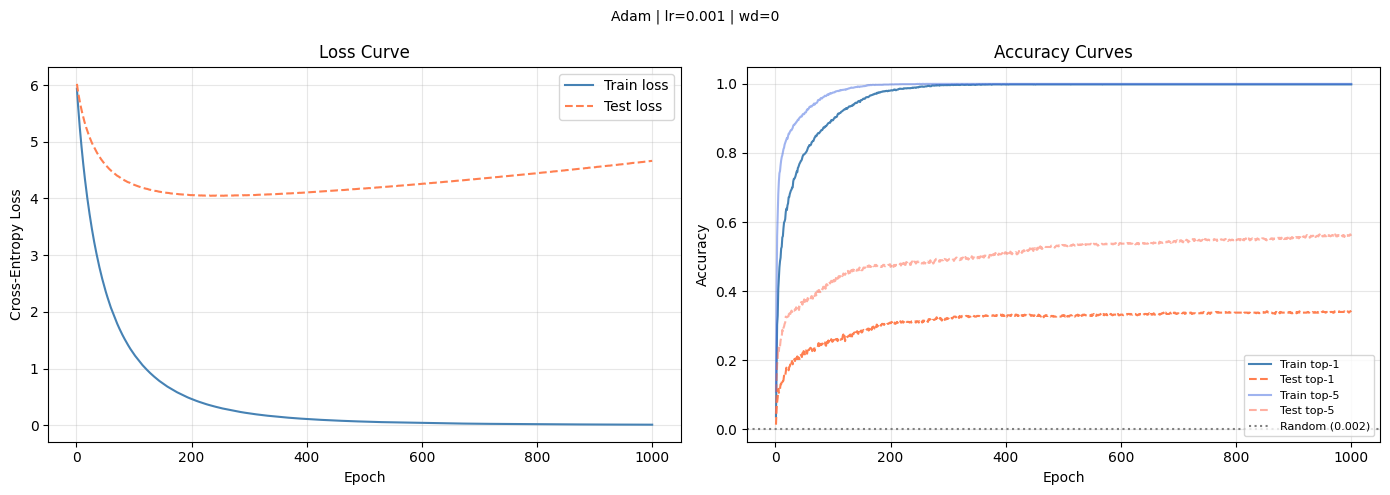

In [101]:
epochs = range(1, N_EPOCHS + 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(epochs, history["train_loss"], label="Train loss", color="steelblue")
ax.plot(epochs, history["test_loss"],  label="Test loss",  color="coral", linestyle="--")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross-Entropy Loss")
ax.set_title("Loss Curve")
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.plot(epochs, history["train_top1"], label="Train top-1", color="steelblue")
ax.plot(epochs, history["test_top1"],  label="Test top-1",  color="coral",    linestyle="--")
ax.plot(epochs, history["train_top5"], label="Train top-5", color="royalblue", alpha=0.5)
ax.plot(epochs, history["test_top5"],  label="Test top-5",  color="tomato",    alpha=0.5, linestyle="--")
ax.axhline(1/n_classes, color="gray", linestyle=":", label=f"Random ({1/n_classes:.3f})")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy Curves")
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

fig.suptitle(f"Adam | lr={LR} | wd={WEIGHT_DECAY}", fontsize=10)
plt.tight_layout()
plt.savefig(EMBEDDINGS_DIR / "training_curves.png", dpi=150, bbox_inches="tight")
plt.show()


## 7. Evaluation

### 7a. Final Metrics

In [13]:
final = evaluate(model, test_loader, DEVICE)
y_pred   = final["preds"].numpy()
y_true   = final["labels"].numpy()

print("=" * 50)
print("FINAL TEST RESULTS")
print("=" * 50)
print(f"  Top-1 Accuracy:  {final['top1']:.4f}  ({final['top1']*100:.1f}%)")
print(f"  Top-5 Accuracy:  {final['top5']:.4f}  ({final['top5']*100:.1f}%)")
print(f"  Test Loss:       {final['loss']:.4f}")
print(f"  Random baseline: {1/n_classes:.4f}  ({100/n_classes:.2f}%)")
print("=" * 50)

FINAL TEST RESULTS
  Top-1 Accuracy:  0.2975  (29.8%)
  Top-5 Accuracy:  0.4702  (47.0%)
  Test Loss:       4.0313
  Random baseline: 0.0023  (0.23%)


### 7b. Per-Class Accuracy

In [ ]:
per_class_acc = {}
for class_idx, class_name in enumerate(le.classes_):
    mask = y_true == class_idx
    if mask.sum() == 0:
        continue
    per_class_acc[class_name] = (y_pred[mask] == class_idx).mean()

sorted_classes = sorted(per_class_acc.items(), key=lambda x: x[1], reverse=True)
accs_all = list(per_class_acc.values())

print(f"Median per-class accuracy: {np.median(accs_all):.4f}")
print(f"Classes with 100% accuracy: {sum(1 for v in accs_all if v == 1.0)}")
print(f"Classes with 0% accuracy:   {sum(1 for v in accs_all if v == 0.0)}")
print("\nHardest pieces:")
for name, acc in sorted_classes[-10:]:
    print(f"  {name:<40} {acc:.2f}")

Median per-class accuracy: 0.0000
Classes with 100% accuracy: 8
Classes with 0% accuracy:   410

Hardest pieces:
  bach__riemenschneider010                 0.00
  bach__riemenschneider012                 0.00
  bach__riemenschneider013                 0.00
  bach__riemenschneider014                 0.00
  bach__riemenschneider015                 0.00
  bach__riemenschneider016                 0.00
  bach__riemenschneider017                 0.00
  bach__riemenschneider018                 0.00
  bach__riemenschneider019                 0.00
  bach__riemenschneider020                 0.00


/tmp/ipython-input-1156353175.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([n.split("__")[-1] for n in display_names], fontsize=8)


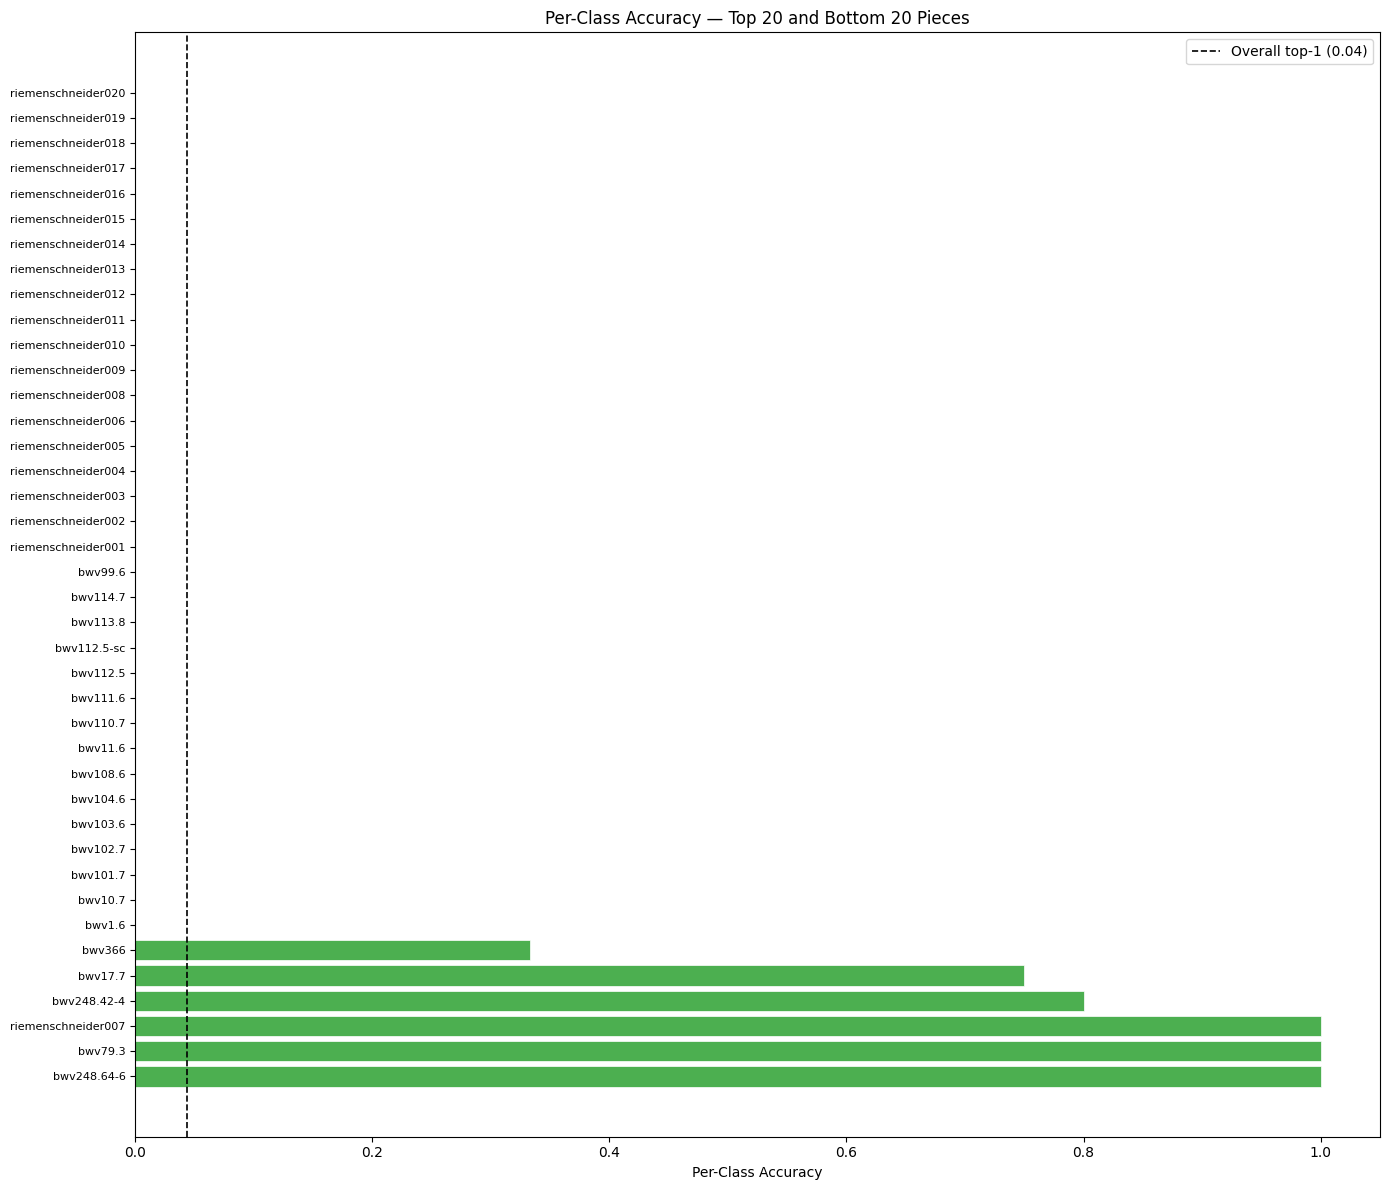

In [ ]:
names  = [c for c, _ in sorted_classes]
accs   = [a for _, a in sorted_classes]
n_show = min(TOP_N_CLASSES_CHART, len(sorted_classes))
half   = n_show // 2

display_names = names[:half] + names[-half:]
display_accs  = accs[:half]  + accs[-half:]
colors = ["#4CAF50"] * half + ["#F44336"] * half

fig, ax = plt.subplots(figsize=(14, max(6, n_show * 0.3)))
ax.barh(display_names, display_accs, color=colors, edgecolor="white", linewidth=0.5)
ax.axvline(final["top1"], color="black", linestyle="--", linewidth=1.2,
           label=f"Overall top-1 ({final['top1']:.2f})")
ax.set_xlabel("Per-Class Accuracy")
ax.set_title(f"Per-Class Accuracy — Top {half} and Bottom {half} Pieces")
ax.set_xlim(0, 1.05)
ax.legend()
ax.set_yticklabels([n.split("__")[-1] for n in display_names], fontsize=8)
plt.tight_layout()
plt.savefig(EMBEDDINGS_DIR / "per_class_accuracy_torch.png", dpi=150)
plt.show()

### 7c. Confusion Matrix

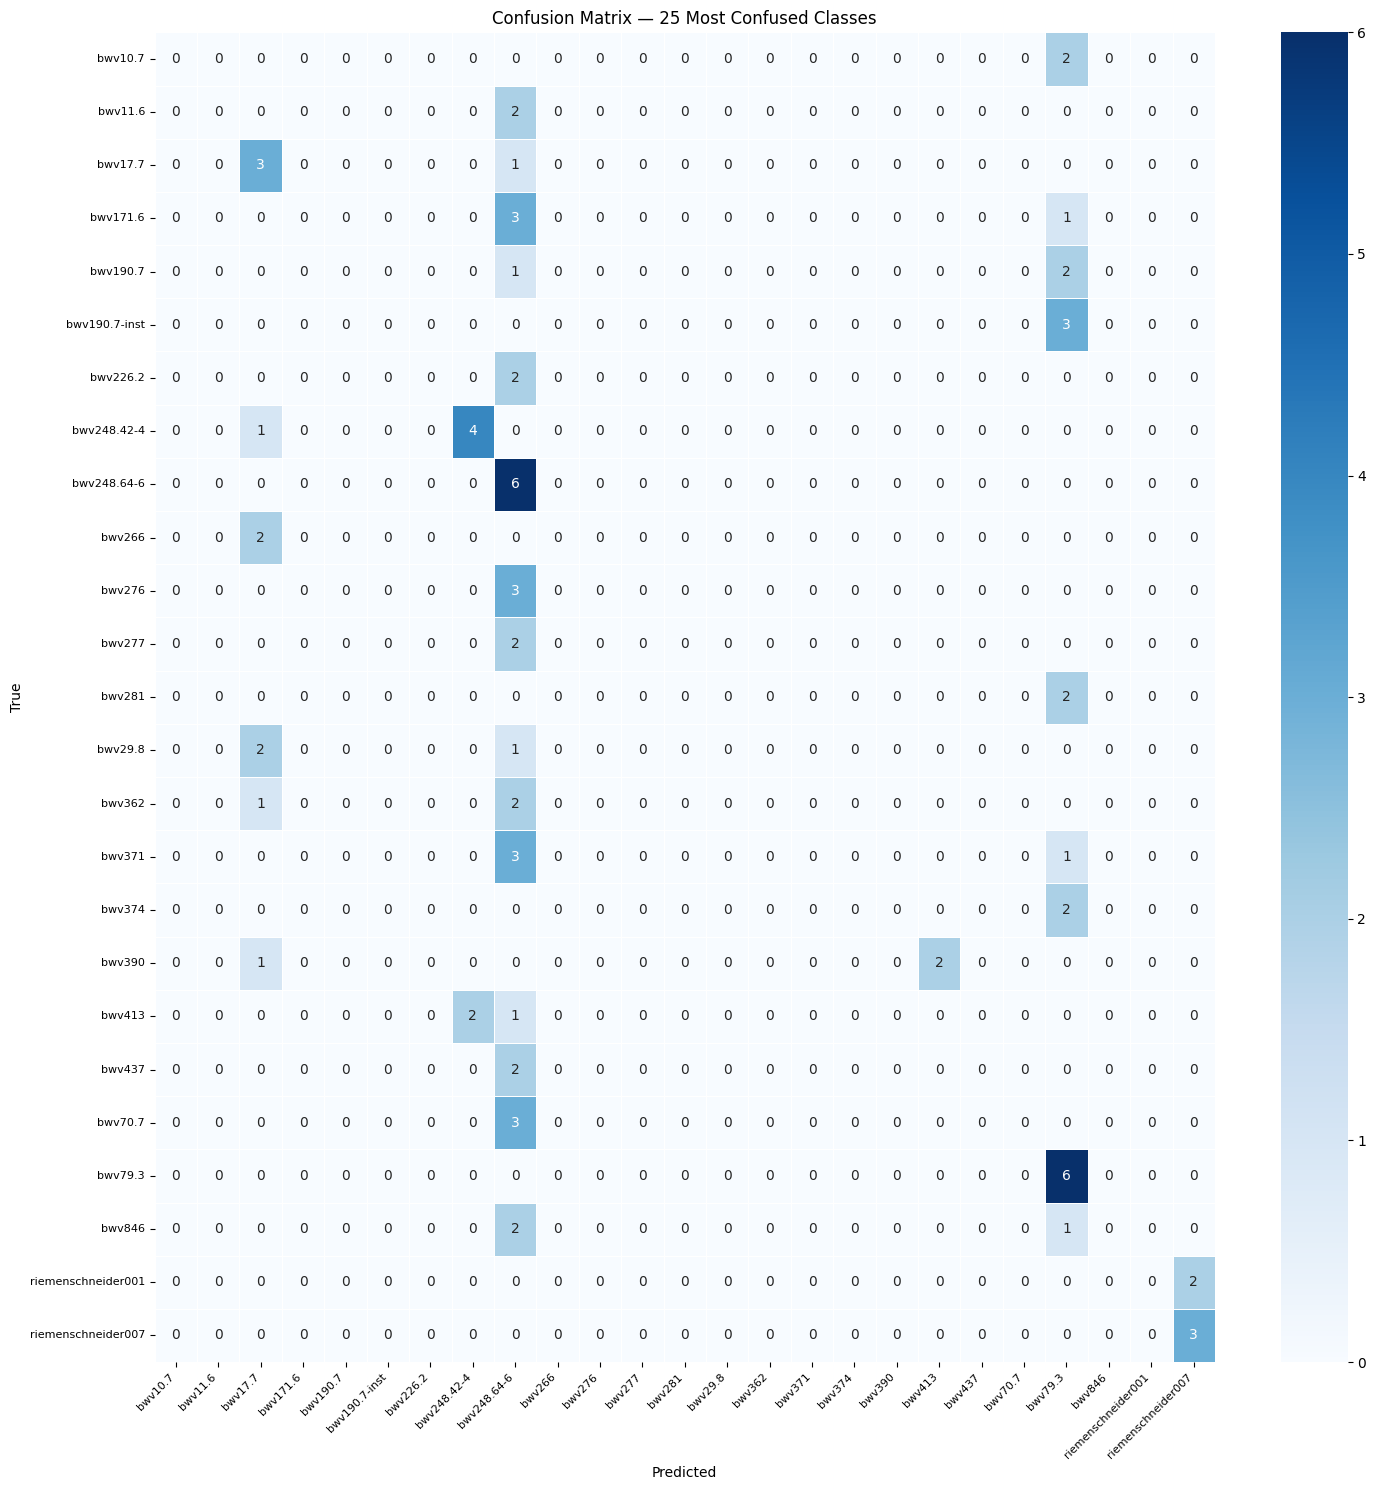

Top confused pairs (true → predicted, count):
  bwv276                         → bwv248.64-6                    (3 snippets)
  bwv371                         → bwv248.64-6                    (3 snippets)
  bwv171.6                       → bwv248.64-6                    (3 snippets)
  bwv70.7                        → bwv248.64-6                    (3 snippets)
  bwv190.7-inst                  → bwv79.3                        (3 snippets)
  bwv374                         → bwv79.3                        (2 snippets)
  bwv266                         → bwv17.7                        (2 snippets)
  bwv277                         → bwv248.64-6                    (2 snippets)
  bwv10.7                        → bwv79.3                        (2 snippets)
  bwv29.8                        → bwv17.7                        (2 snippets)
  bwv846                         → bwv248.64-6                    (2 snippets)
  bwv281                         → bwv79.3                        (2 snippets)
  bwv1

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

cm_errors = cm.copy()
np.fill_diagonal(cm_errors, 0)

flat_indices   = np.argsort(cm_errors.ravel())[::-1][:TOP_N_CONFUSED]
top_true_idx, top_pred_idx = np.unravel_index(flat_indices, cm_errors.shape)

involved = sorted(set(top_true_idx) | set(top_pred_idx))
sub_cm   = cm[np.ix_(involved, involved)]
names_short = [le.classes_[i].split("__")[-1] for i in involved]

fig, ax = plt.subplots(figsize=(max(10, len(involved) * 0.6),
                                max(8,  len(involved) * 0.6)))
sns.heatmap(sub_cm, xticklabels=names_short, yticklabels=names_short,
            annot=True, fmt="d", cmap="Blues", linewidths=0.5, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(f"Confusion Matrix — {len(involved)} Most Confused Classes")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(EMBEDDINGS_DIR / "confusion_matrix_torch.png", dpi=150)
plt.show()

print("Top confused pairs (true → predicted, count):")
for ti, pi in zip(top_true_idx, top_pred_idx):
    count = cm[ti, pi]
    if count > 0:
        print(f"  {le.classes_[ti].split('__')[-1]:<30} → "
              f"{le.classes_[pi].split('__')[-1]:<30} ({count} snippets)")

### 7d. UMAP Embedding Space

In [ ]:
try:
    import umap
except ImportError:
    print("Run: pip install umap-learn")
    raise SystemExit

print("Fitting UMAP on raw MERT embeddings...")

reducer = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS, n_components=2,
                    metric="cosine", random_state=SEED, verbose=True)
X_train_2d = reducer.fit_transform(X_train_np)
X_test_2d  = reducer.transform(X_test_np)
print("UMAP done.")


/tmp/ipython-input-1087715980.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", n_classes)


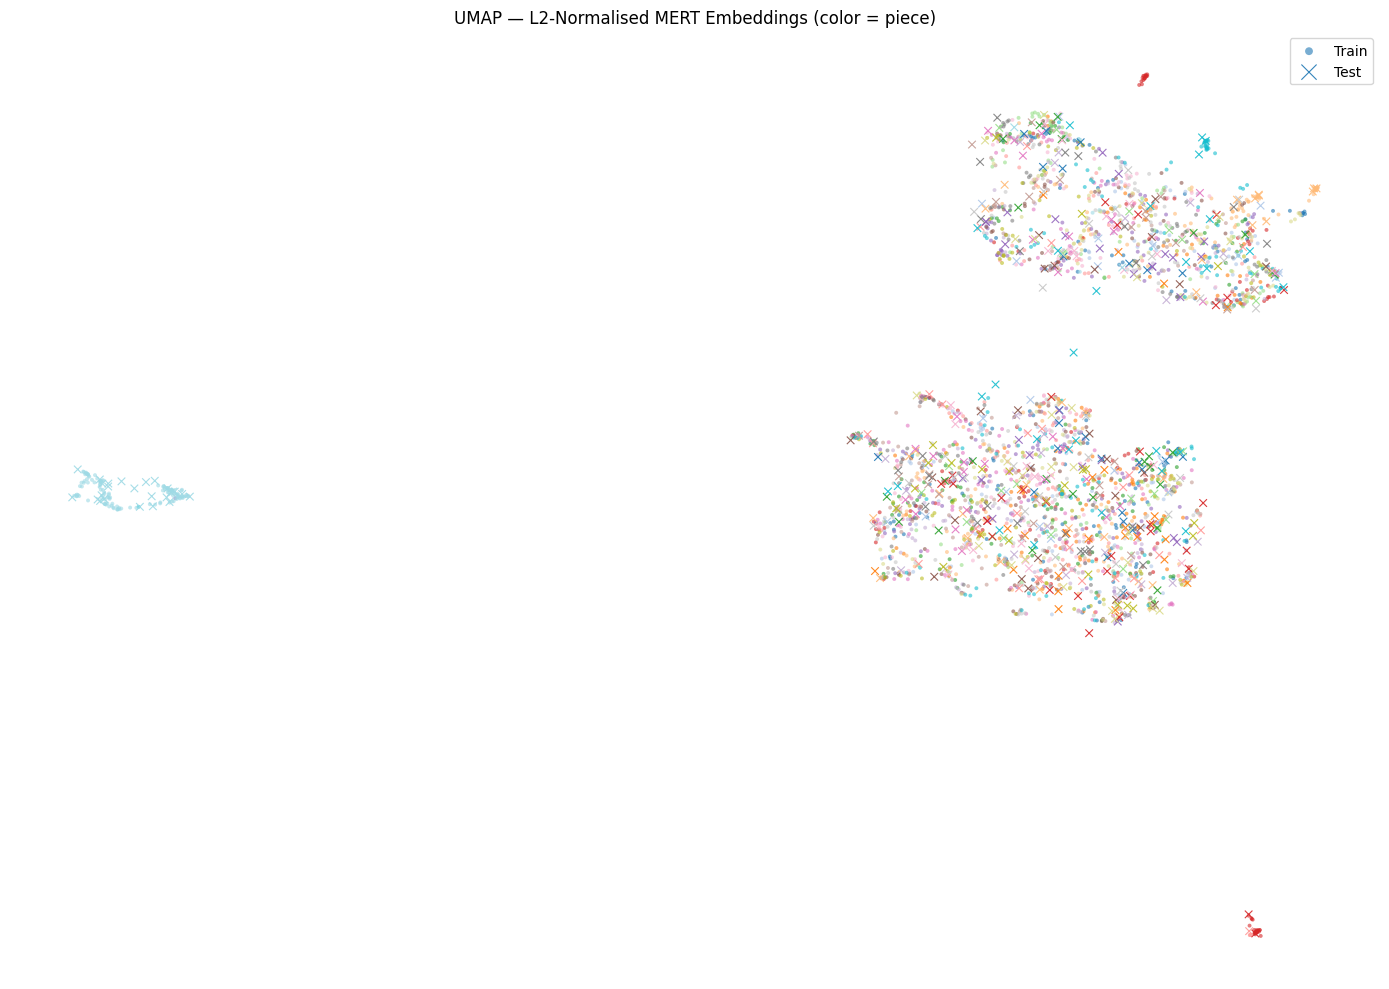

In [ ]:
cmap = plt.cm.get_cmap("tab20", n_classes)

fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(X_train_2d[:, 0], X_train_2d[:, 1],
           c=y_train_np, cmap=cmap, s=8, alpha=0.6, linewidths=0, label="Train")
ax.scatter(X_test_2d[:, 0],  X_test_2d[:, 1],
           c=y_test_np,  cmap=cmap, s=30, alpha=0.9, marker="x",
           linewidths=0.8, label="Test")
ax.set_title("UMAP — L2-Normalised MERT Embeddings (color = piece)")
ax.legend(markerscale=2)
ax.axis("off")
plt.tight_layout()
plt.savefig(EMBEDDINGS_DIR / "umap_torch.png", dpi=150)
plt.show()

## 8. Optimizer Comparison Helper

Re-run training with a different optimizer config and compare curves side by side.
Useful for comparing SGD vs. Nesterov for your optimization course.

In [ ]:
# Class weights: inverse frequency weighting so every piece contributes
# equally to the loss regardless of how many snippets it has.
# Without this, pieces with more snippets dominate training.
counts  = np.bincount(y_train_np, minlength=n_classes).astype(np.float32)
weights = 1.0 / (counts + 1e-6)
weights = weights / weights.sum() * n_classes   # normalise so mean weight = 1
class_weights = torch.from_numpy(weights).float().to(DEVICE)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)

# Pass class_weights so rare pieces are upweighted proportionally.
criterion = nn.CrossEntropyLoss(weight=class_weights)

print(f"Optimizer: Adam | lr={LR} | weight_decay={WEIGHT_DECAY}")
print(f"Loss: CrossEntropyLoss with inverse-frequency class weights")
print(f"Weight range: {weights.min():.3f} – {weights.max():.3f}")


In [ ]:
epochs = range(1, 101)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ["steelblue", "coral", "seagreen"]

for (label, hist), color in zip(histories.items(), colors):
    axes[0].plot(epochs, hist["test_loss"],  label=label, color=color)
    axes[1].plot(epochs, hist["test_top1"],  label=label, color=color)

axes[0].set_title("Test Loss — Adam vs SGD variants")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cross-Entropy Loss")
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.3)

axes[1].set_title("Test Top-1 Accuracy — Adam vs SGD variants")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(EMBEDDINGS_DIR / "optimizer_comparison.png", dpi=150)
plt.show()
print("Saved: optimizer_comparison.png")


## 9. Summary

In [ ]:
print("=" * 50)
print("PYTORCH BASELINE SUMMARY")
print("=" * 50)
print(f"  Model:           LinearClassifier (d={d} → C={n_classes})")
print(f"  Normalization:   L2 inside forward pass")
print(f"  Optimizer:       SGD | nesterov={NESTEROV}")
print(f"  lr={LR} | momentum={MOMENTUM} | weight_decay={WEIGHT_DECAY}")
print(f"  Epochs:          {N_EPOCHS}")
print()
print(f"  Top-1 Accuracy:  {final['top1']:.4f}  ({final['top1']*100:.1f}%)")
print(f"  Top-5 Accuracy:  {final['top5']:.4f}  ({final['top5']*100:.1f}%)")
print(f"  Random baseline: {1/n_classes:.4f}  ({100/n_classes:.2f}%)")
print(f"  Median per-class:{np.median(accs_all):.4f}")
print("=" * 50)

PYTORCH BASELINE SUMMARY
  Model:           LinearClassifier (d=768 → C=430)
  Normalization:   L2 inside forward pass
  Optimizer:       SGD | nesterov=False
  lr=0.1 | momentum=0.9 | weight_decay=0.0001
  Epochs:          100

  Top-1 Accuracy:  0.0441  (4.4%)
  Top-5 Accuracy:  0.0883  (8.8%)
  Random baseline: 0.0023  (0.23%)
  Median per-class:0.0000
